In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import export_graphviz
import IPython
import graphviz
import re
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, merge

Using TensorFlow backend.


Для эксперементов была взята выборка, посвященная исследованию падений людей в пожилом возрасте. В данной выборке необходимо решить задачу классификации - определение типа движения.

In [0]:
df_raw = pd.read_csv('falldetection.csv', low_memory=False)

Набор данных состоит из шести независимых переменных и одной зависимой переменной. Независимыми переменными выступают: 
1. TIME - время мониторинга добровольца 
2. SL - уровень сахара в крови 
3. EGG - ЭГГ мониторинг скорости 
4. BP - кровяное давление
5. HR - частота сердечных сокращений
6. CIRCLUATION - кровообращение

Зависимая переменная, ACTIVITY, может принимать значение от 0 до 5, где 

0 - Стоящее положение, 1 - Ходьба, 2 - Сидящее положение, 3 - Падение, 4 - Судороги, 5 - Бег

In [0]:
df_raw.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
0,3,4722.92,4019.64,-1600.00,13,79,317
1,2,4059.12,2191.03,-1146.08,20,54,165
2,2,4773.56,2787.99,-1263.38,46,67,224
3,4,8271.27,9545.98,-2848.93,26,138,554
4,4,7102.16,14148.80,-2381.15,85,120,809


In [0]:
df_raw.describe()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
count,16382.000000,16382.000000,1.638200e+04,1.638200e+04,16382.000000,16382.000000,16382.000000
mean,2.361494,10936.842478,7.527198e+04,-5.621125e+03,58.251068,211.536992,2894.341472
std,1.739195,5261.463601,1.275022e+05,1.082209e+05,48.292926,129.949521,3825.927830
min,0.000000,1954.230000,4.222420e+01,-1.262600e+07,0.000000,33.000000,5.000000
25%,0.000000,7263.685000,9.941170e+03,-5.630000e+03,25.000000,119.000000,587.000000
50%,3.000000,9769.355000,3.118920e+04,-3.361275e+03,44.000000,180.000000,1581.000000
75%,4.000000,13481.650000,8.076145e+04,-2.150000e+03,78.000000,271.000000,3539.000000
max,5.000000,50895.500000,2.426140e+06,1.410000e+06,533.000000,986.000000,52210.000000


Пропущенных значений в выборке нет.


In [0]:
df_raw.isnull().sum()

ACTIVITY       0
TIME           0
SL             0
EEG            0
BP             0
HR             0
CIRCLUATION    0
dtype: int64

Проанализировав данные, можно перейти к обучению модели. Прежде всего необходимо отделить независимые переменные от того, что мы будем предсказывать, а именно тип активности.

In [0]:
X = df_raw.iloc[:,1:]
y = df_raw.ACTIVITY

classes = df_raw.ACTIVITY.unique()

Датасет не содержит пропущенных значений, поэтому можно перейти к разделению выборки в соотношении 8:2 с помощью train_test_split из scikit-learn. Двадцать процентов выборки будет использоваться в качестве тестовой выборки для оценки точности окончательной модели. Оставшиеся 80% разделим в соотношении 8:2 на обучающую выборку и проверочную выборку (validation set).

In [0]:
def split_values(x, y): return train_test_split(x, y, test_size = 0.2, random_state = 1)

X_train, X_test, y_train, y_test = split_values(X, y)
X_train, X_valid, y_train, y_valid = split_values(X_train, y_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((10484, 6), (10484,), (2621, 6), (2621,), (3277, 6), (3277,))

In [0]:
X_train

,TIME,SL,EEG,BP,HR,CIRCLUATION
1212,9978.85,22245.80,-1760.000,25,182,1212
9847,8140.29,30545.00,-2599.000,109,169,1803
1468,22801.90,240508.00,-10800.000,86,537,8350
6304,12308.90,78261.00,-5360.000,50,272,3539
3546,13703.80,139452.00,-6680.000,43,315,5844
1862,18492.30,160740.00,-8860.000,90,388,6290
8114,18722.30,161716.00,-6515.660,87,352,6744
9116,7419.06,7846.00,-1990.000,15,115,457
7063,9199.75,26558.30,-2983.540,102,158,1403
7191,12817.30,58183.60,-1550.000,55,223,2822


Функция print_score была создана для вывода качества модели. Первое значение соответствует accuracy модели на train set, а второе значение - accuracy модели на validation set.

In [0]:
def print_score(m, normalize=False, conf_matrix=False): 
    if conf_matrix:
        plot_confusion_matrix(y_valid, m.predict(X_valid), classes=classes, normalize=normalize,
                              title='Normalized confusion matrix')
        plt.show()
    res = [accuracy_score(y_train, m.predict(X_train)), accuracy_score(y_valid, m.predict(X_valid))]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

Функция plot_accuracy_models создана для построения графика, отражающего тенденцию изменения качества модели от изменения одно из гиперпараметров.

In [0]:
def plot_accuracy_models(parameters, train_scores, valid_scores):
    line1, = plt.plot(parameters, train_scores, 'b', label='Train accuracy')
    line2, = plt.plot(parameters, valid_scores, 'r', label='Validation accuracy')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('Parameter value')
    plt.show()


Функция accuracy_scores создана для вычисления значения качества модели на обучающей выборке и на validation set

In [0]:
def accuracy_scores(m):
    valid_scores.append(accuracy_score(y_valid, m.predict(X_valid)))
    train_scores.append(accuracy_score(y_train, m.predict(X_train)))
    return valid_scores, train_scores

# Random Forests

Функция plot_confusion_matrix, взятая с официалього сайта scikitlearn, позволяет вывести confusion_matrix в более наглядном виде.

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Функция draw_tree была взята из библиотеки fastai для наглядного построения дерева решений.

In [0]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

## Single tree

Построим случайный лес с одним деревом глубины 3.

In [0]:
rf = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

[0.3655093475772606, 0.3700877527661198]


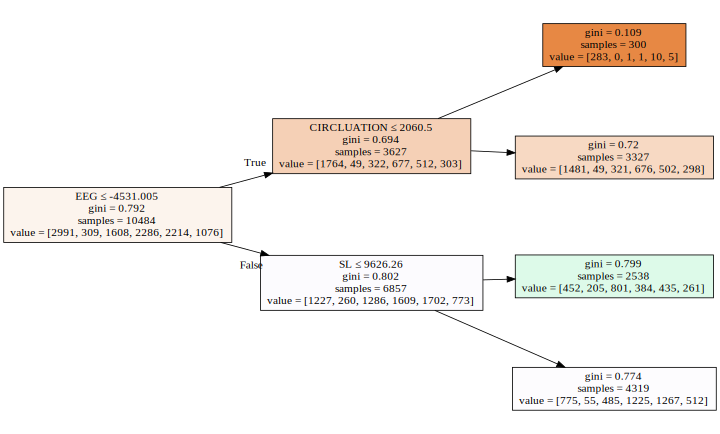

In [0]:
draw_tree(rf.estimators_[0], X_train, precision=3)

## Parameters tuning


Построим базовую модель случайного леса, которую в дальнейшем будем улучшать, добавляя дополнительные гиперпараметры.

In [0]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)
print_score(rf)

[0.9876955360549409, 0.7584891262876765]


Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Для выбора правильного количества деревьев можно оценить, как влияет этот параметр на финальное качество модели. Для этого обучим разные леса с разным количеством деревьев.

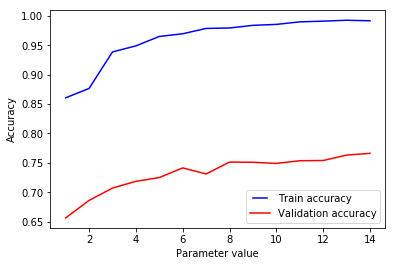

In [0]:
estimators = np.arange(1, 15)
train_scores = []
valid_scores = []

for e in estimators:
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=e)
    rf.fit(X_train, y_train)
    accuracy_scores(rf)
    
plot_accuracy_models(estimators, train_scores, valid_scores)

Был построен график, отражающий зависимость accuracy модели от количества деревьев, на котором можно заметить, что после примерно 30 деревьев качество модели не изменяется, поэтому выберем n_estimators = 30.

In [0]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

[0.9963754292254865, 0.769172071728348]


In [0]:
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

[0.9938000763067532, 0.7619229301793209]


In [0]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

[0.9870278519648988, 0.7531476535673407]


Еще одним параметром случайного леса является min_samples_leaf, который задает минимальное количество строк в узле. Попробуем изменить его количество.

In [0]:
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1,  min_samples_leaf=3)
rf.fit(X_train, y_train)
print_score(rf)

[0.8994658527279664, 0.747806180847005]


Качество модели ухудшилось, поэтому оставим min_samples_leaf = 1. Следующий параметр max_depth представляет максимальную глубину каждого дерева. Чем глубже дерево, тем оно собирает больше информации о данных. Попробуем обучить лес c разным значением max_depth.

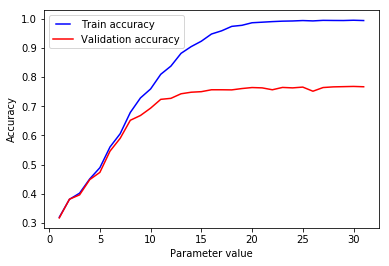

In [0]:
max_depth = np.arange(1, 32)
train_scores = []
valid_scores = []

for d in max_depth:
    rf = RandomForestClassifier(n_estimators=15, n_jobs=-1, max_depth=d)
    rf.fit(X_train, y_train)
    accuracy_scores(rf)
    
plot_accuracy_models(max_depth, train_scores, valid_scores)

Построенный график отражает зависимость качества модели от значения параметра max_depth. На графике видно, что после max_depth = 15 качество модели почти не менятся, попробуем обучить модель с max_depth = 15

In [0]:
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1,  max_depth=15)
rf.fit(X_train, y_train)
print_score(rf)

[0.9270316673025563, 0.7523845860358642]


Качество модели немного ухудшилось, попробуем изменить следующий параметр max_features, который определяет какое максимальное количество переменных, которые следует учитывать при поиске лучшего разделения.

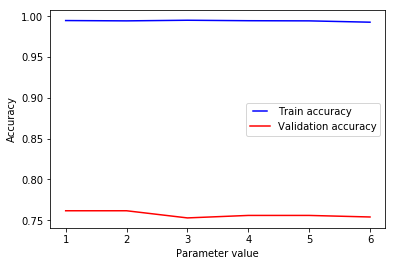

In [0]:
max_features = np.arange(1, X_train.shape[1] + 1)
train_scores = []
valid_scores = []

for f in max_features:
    rf = RandomForestClassifier(n_estimators=15, n_jobs=-1, max_features=f)
    rf.fit(X_train, y_train)
    accuracy_scores(rf)
    
plot_accuracy_models(max_features, train_scores, valid_scores)

In [0]:
m = RandomForestClassifier(n_estimators=15, n_jobs=-1, max_features=2)
m.fit(X_train, y_train)
print_score(m)

[0.9938954597481877, 0.7619229301793209]


В итоге изменение таких гиперпараметров, как max_features, max_depth, min_samples_leaf, не помогло улучшить качество модели.

In [0]:
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

[0.9943723769553605, 0.764975200305227]


In [0]:
accuracy_score(y_test, rf.predict(X_test))

0.7451937747940189

#KNN

Прежде всего для построения нейронной сети необходимо стандартизовать данные (для этого воспользуемся StandardScaler из sklearn), после этого среднее значение каждого столбца (объекта) в выборке было равно 0, а стандартное отклонение – 1. 

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

Построим базовую модель KNN.

In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print_score(knn)
knn

[0.7352155665776421, 0.6341091186570011]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Поиск наилучших параметров для алгоритма KNN будет осуществляться через GridSearchCV. Осуществим поиск по параметрам: n_neighbors = 1, 3, 5, 7; weights = uniform, distance; metric = euclidean, manhattan, minkowski.

In [0]:
grid_params = {
    'n_neighbors':[1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, cv =3)

gs_result = gs.fit(X_train, y_train)

print(gs_result.best_params_)
print(gs_result.best_estimator_)

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


In [0]:
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')
knn.fit(X_train, y_train)
print_score(knn)

[0.8031285768790538, 0.6570011446012972]


In [0]:
accuracy_score(y_test, knn.predict(X_test))

0.648764113518462

#Neural Network

In [0]:
def plot_accuracy_history(m):
  plt.plot(model.history.history["acc"], label='Train accuracy')
  plt.plot(model.history.history["val_acc"], label='Validation accuracy')
  plt.legend(['train', 'valid'], loc='upper left')

In [0]:
def plot_loss_history(m):
  plt.plot(model.history.history["loss"])
  plt.plot(model.history.history["val_loss"])
  plt.legend(['train', 'valid'], loc='upper right')

In [0]:
def fitting_model(m, verbose=0):
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_train,y_train, batch_size=10, epochs=100, validation_data=(X_valid, y_valid), verbose=verbose)
  print (f'Accuracy (validation set): {model.evaluate(X_valid, y_valid, verbose=0)[1]}.')

Прежде всего для построения нейронной сети необходимо стандартизовать данные (для этого воспользуемся StandardScaler из sklearn), после этого среднее значение каждого столбца (объекта) в выборке было равно 0, а стандартное отклонение – 1. 

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

Кроме того, поскольку будет использована категориальная кросс-энтропия в качестве функции потерь, то нужно преобразовать зависимую переменную, хранящую тип активности, в двоичную матрицу классов.

In [0]:
y_train = to_categorical(y_train.values)
y_valid = to_categorical(y_valid.values)
y_test = to_categorical(y_test.values)

Сначала начнем с базовой модели, а потом будем её улучшать на каждом этапе.

In [0]:
model = Sequential()
model.add(Dense(6, input_dim=6,activation='softmax'))

fitting_model(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Accuracy (validation set): 0.38305990074436796.


Попробуем построить 7 нейронных сетей, где с каждой новой сетью будем добавлять по одному слою и количество нейронов увеличивать на 6 

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.44067149941632877.


In [0]:
model = Sequential()
model.add(Dense(18, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.5165967185822028.


In [0]:
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.5505532241422499.


In [0]:
model = Sequential()
model.add(Dense(30, input_dim=6, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.5963372757806891.


In [0]:
model = Sequential()
model.add(Dense(36, input_dim=6, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Instructions for updating:
Use tf.cast instead.
Accuracy (validation set): 0.629530713604589.


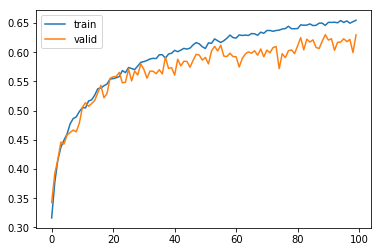

In [0]:
plot_accuracy_history(model)

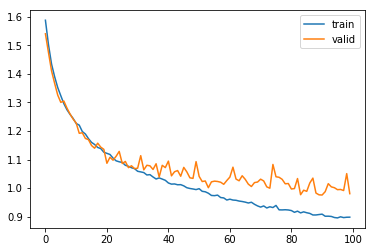

In [0]:
plot_loss_history(model)

In [0]:
model = Sequential()
model.add(Dense(42, input_dim=6, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.6611980161608653.


Возможно, для того чтобы улучшить качество модели, необходимо увеличить количество нейронов в каждом слое. Следующая построенная нейронная сеть, состоящая из 5 слоев (количество нейронов – 128, 64, 32, 16, 6), показала немного лучше результат – 0,64. Попробуем построить еще несколько нейронных сетей с похожей архитектурой, увеличивая каждый раз количество нейронов в два раза. 

In [0]:
model = Sequential()
model.add(Dense(128, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.6550934756589.


In [0]:
model = Sequential()
model.add(Dense(256, input_dim=6, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.6737886302710399.


In [0]:
model = Sequential()
model.add(Dense(512, input_dim=6, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Accuracy (validation set): 0.6917207174199267.


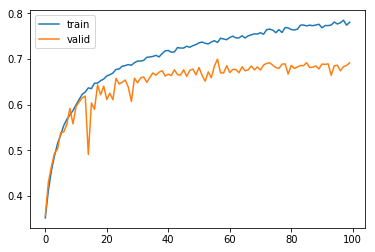

In [0]:
plot_accuracy_history(model)

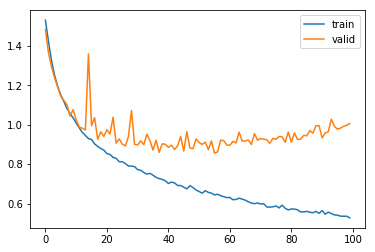

In [0]:
plot_loss_history(model)

In [0]:
model = Sequential()
model.add(Dense(512, input_dim=6, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

fitting_model(model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Accuracy (validation set): 0.6821823728671287.


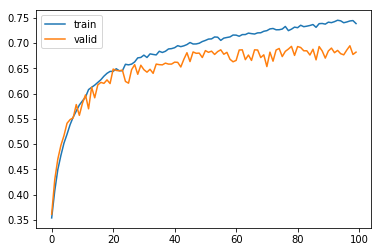

In [0]:
plot_accuracy_history(model)

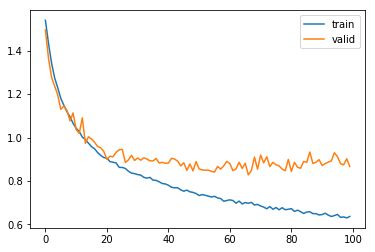

In [0]:
plot_loss_history(model)

In [0]:
model = Sequential()
model.add(Dense(512, input_dim=6, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=10, epochs=200, validation_data=(X_valid, y_valid))
print (f'Accuracy (validation set): {model.evaluate(X_valid, y_valid, verbose=0)[1]}.')

Train on 10484 samples, validate on 2621 samples
Epoch 1/200
10484/10484 [==============================] - 7s 637us/step - loss: 1.5620 - acc: 0.3380 - val_loss: 1.4699 - val_acc: 0.3926
Epoch 2/200
10484/10484 [==============================] - 6s 580us/step - loss: 1.4680 - acc: 0.3877 - val_loss: 1.4466 - val_acc: 0.4033
Epoch 3/200
10484/10484 [==============================] - 6s 578us/step - loss: 1.3899 - acc: 0.4231 - val_loss: 1.3944 - val_acc: 0.4014
Epoch 4/200
10484/10484 [==============================] - 6s 617us/step - loss: 1.3341 - acc: 0.4564 - val_loss: 1.3317 - val_acc: 0.4746
Epoch 5/200
10484/10484 [==============================] - 7s 638us/step - loss: 1.2874 - acc: 0.4807 - val_loss: 1.2829 - val_acc: 0.4826
Epoch 6/200
10484/10484 [==============================] - 6s 578us/step - loss: 1.2727 - acc: 0.4778 - val_loss: 1.2452 - val_acc: 0.4914
Epoch 7/200
10484/10484 [==============================] - 6s 582us/step - loss: 1.2454 - acc: 0.4960 - val_loss: 1.2

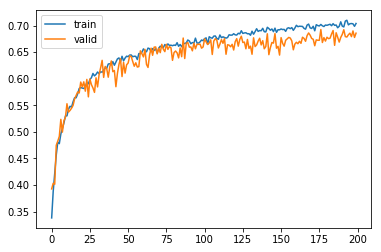

In [0]:
plot_accuracy_history(model)

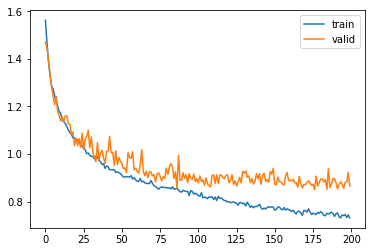

In [0]:
plot_loss_history(model)

In [0]:
print (f'Accuracy (test set): {model.evaluate(X_test, y_test)[1]}.')

3277/3277 [==============================] - 0s 57us/step
Accuracy (test set): 0.6838571864873998.
